# SAIL Application Project: Modeling Strike-Probability in Baseball

#### Carter Hall
#### December 28, 2022

<hr></hr>

### Abstract

At-bats in baseball are interactions between the offense and defense; games are won and lost at-the-plate. As such, determine what allows pitchers to be successful from an analytical, data-driven perspective is vital to constructing a strategy to win more games. This analysis introduces the techniques of Extreme Gradient Boosting and Bayesian Hyperparameter-Optimization to create an XGBoost classifier of strike-generating pitches, commonly understood to be advantageous to the defense. ROC and Precision-Recall metrics are used to evaluate the improvement optimization made on the predictions of a testing dataset, scraped from the 2012-2022 MLB seasons using the pybaseball package. Future work, including additional parameters that could be investigated, is identified; additionally, the model and generating code are made public in this analysis and accompanying repository.

### Introduction

In the sport of baseball, an *at-bat* is defined as a sequence of interactions between pitcher and batter in which the batter recieves pitches and takes subsequent action based on observed characteristics of the pitch. At the Major League Baseball (MLB) level, this information-gathering process spans milliseconds on average, hence why, for example, a batting average -- the proportion of at-bat a hitter reaches first base, typically ignoring walks, with respect to their total number of at-bats -- of around 0.300 has historically been a mark of an offensively productive player. Data analytics in recent decades, however, has (and continues to) tried to supplant antiquated perceptions of skill with quantitative metrics that dive further into the intricacies of the sport, in order to identify what makes great players... great.

This analysis positions itself not as an advocate for the hitter, but rather for their adversary, the pitcher; in particular, a probabilistic model built with the recently popular machine-learning technique that is Extreme Gradient Boosting (XGBoost, or XGB for short) will attempt to characterize what allows pitchers to be so successful at generating strikes in at-bats. Pitch-by-pitch data from the past ~10 seasons of Major League Baseball, complete with descriptive metrics such as release velocity, spin rate, and the outcome offer context and important insight into identifying how major-league pitchers excel in their craft.

### Data Preprocessing

Before introducing the modeling frameworks with which this analysis will be conducted, it is pivotal to propertly source and investigate the underlying data. Using Python 3.10 and the <a href="https://pypi.org/project/pybaseball/">pybaseball</a> package, data are collected from a number of prominent baseball-data warehouses, namely Baseball Savant, Baseball Reference, and FanGraphs, and then stored, both as an external file and in an in-memory dataframe. (The external file will be uploaded to a repository containing the code and writeup of this project, linked later in this analysis.)

In [1]:
from pybaseball import statcast, cache
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder,StandardScaler, LabelBinarizer
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score,precision_recall_curve,average_precision_score,precision_score,roc_curve, auc, accuracy_score
import seaborn as sns
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

# Uncomment if in-need of a fresh copy of the data! WARNING: This takes a while.
# cache.enable()
# data = pd.DataFrame(statcast(start_dt = "2012-01-01", end_dt = "2022-12-23"))
# data.to_csv("./pitch12to22.csv", index = False)

# Uncomment if in-need of a fresh, local copy of data.
data = pd.read_csv("./pitch12to22.csv",low_memory=False)

Before continuing, it may be helpful to note the columns of the dataset:

In [2]:
data.columns

Index(['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'events',
       'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed',
       'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1',
       'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
       'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y',
       'estima

Now that the data has been obtained, we must first take note of its contents; the data is stored in a *7665665* (!) $\times$ *92* table and contains information such as 
- The *pitch type* (e.g., Four-Seam Fastball -- FF, Curveball -- CU)
- The *release position* as an (x,z)-coordinate.
- The *description* of what occurred after the pitch was thrown. (This will help create the response variable.)
- The *name*/*ID* of the pitcher
and many other variables.

However, there *are* 'NaN' observations in the dataset, indicating an instance in which a data-capturing process failed to record information, or a case in which no applicable value of a variable could be attributed. After identifying variables of-interest, any 'NaN' observations will be omitted.

In addition to sourcing the data, an important step in **exploratory data analysis** (EDA), the process of wrangling, cleaning, and preparing data for modeling, is to clean the data -- this may involve the creation of additional variables to make information more processable by a modeling framework, or by performing procedures, such as standardization, to address concerns of outliers and of the raw values themselves being potentially misleading for when a model is trained and/or later validated.

In baseball datasets, a prime target for data cleaning is the *pitch type* column; some data-capturing software may, for example, appropriate the label 'fastball' to refer to four-seam, two-seam, cut, or other variant, while others (such as the data captured in this analysis) may appropriate individual labels to each of these. When performing the analysis, the function below will be used to get an idea of both the labels used for pitch-typing (and other categorical metrics), and the relative amounts in which they occur.

In [3]:
def count_by_factor(v):
    '''
    A function to return a dictionary containing counts for each 
    observed level of a factor within a list, 'v'.
    '''
    d = dict()
    for i in range(len(v)):
        if v[i] not in d.keys():
            d[v[i]] = d.get(v[i],0) + 1
        else:
            d[v[i]] += 1
    return d

Before handling 'NaN' values, the gathered data will be filtered to only consider columns of-interest to the analysis. The following observations are of importance:
- The models are determining the probability of an individual pitch resulting in a 'swing-and-miss' event -- a strike-swinging, that is. **Intuitively**, the only information that can substantially impact a pitch-outcome are related to the pitcher and hitter. For the purposes of this analysis, focus is paid primarily to the pitcher and the data they supply when throwing a pitch; this includes the spin, speed, pitch-type, and, ultimately, the location. 
- As no two batters are the same, integrating analysis to understand hitters' weaknesses is desirable for analyzing in-game scenarios. For the sake of allowing these models to be utilized in practices (i.e., when/if there is no hitter), hitter 'profiling' will not be integrated into this analysis; although, *this could be a major emphasis in future work*.
- It may be ideal to create models for *different pitchers* and incorporate the various 'stuff(s)' (yes, this is a baseball term!) present in different signature pitches and/or pitch combinations. Rather than proceeding in this direction, the created model might have value in different analyses focused *on* specific pitchers! 

With that being said, the following code filters the data:

In [4]:
# Filtered data
data = data.loc[:,["pitch_type","release_speed","release_pos_x","release_pos_z","description","zone","p_throws","pfx_x","pfx_z","plate_x","plate_z","spin_axis"]]

Other columns considered included the *spin_dir* column, but it unfortunately was entirely 'NaN.' The now 12-column dataset contains quantifiable information representing the time prior to a ball being caught by the catcher. Outright removing of any observation with 'NaN' values in this trimmed dataset removes >80% of the observations, although there are over 1,000,000 pitches remaining. If the resultant predictions are somewhat nonsensical (i.e., every prediction being tagged as a strike), these 'NaN' values can be imputed via regression or other methods to increase the number of available observations.

In [5]:
# Setting parameter to 'False' in-case of clerical error -- removes need
# to re-fetch the large dataset
data = data.dropna(axis=0,inplace=False) 

Returning to the pitch-type column, the below histogram shows the raw counts of different pitch (sub-)categories before re-labelling; as expected, pitches such as the Four-Seam Fastball (FF), Slider (SL), and Changeup (CH), often integral to pitchers' arsenals, occur in large frequency. Others, namely the Cut Fastball (FC), are mechanically different from these main categories, and are thus labeled separately.

The following notes are also important:
- The Fastball (FA) can be reasonably assumed to be the most common variant, the Four-Seam Fastball (FF). 
- The Sinker (SI/FS) will be combined into one category, under the label 'SI.'

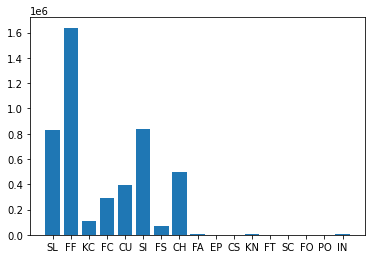

In [6]:
counts = count_by_factor(list(data["pitch_type"]))
plt.bar(counts.keys(),counts.values())
plt.show()

Some pitches, like the Eephus (EP), are *incredibly* rare; a small number of major-league pitchers use Eephus pitches, and so, like the Intentional Walk (IN) or Pitch-Out (PO/FO), pitch types with very few observations (or in which common-sense would dictate a batter not to swing, e.g., being awarded a base) will be removed from consideration in the model. Lastly, any pitch-type label not presented in <a href="https://library.fangraphs.com/pitch-type-abbreviations-classifications/">this FanGraphs article</a> will be removed.

In [7]:
def usedPitches(p):
    ptypes = ["SL","FF","KC","CU","SI","FS","FC","CH","FA","KN"]
    return any([pt == p for pt in ptypes])

In [8]:
# Trimmed dataset to exclude rare pitches and intentional walks
data = data.iloc[[idx for idx,pt in enumerate(data["pitch_type"]) if usedPitches(pt)]]
data.head()

,pitch_type,release_speed,release_pos_x,release_pos_z,description,zone,p_throws,pfx_x,pfx_z,plate_x,plate_z,spin_axis
0,SL,89.2,-0.06,6.14,hit_into_play,14.0,R,0.41,0.37,1.05,2.39,137.0
1,FF,93.9,-0.18,5.94,hit_into_play,8.0,R,-0.33,1.57,0.06,2.08,210.0
2,FF,93.0,-0.09,5.97,hit_into_play,8.0,R,-0.20,1.63,0.04,1.57,212.0
3,SL,88.1,-0.15,6.03,hit_into_play,14.0,R,0.61,0.21,0.92,1.43,120.0
4,SL,89.0,-0.25,6.06,foul,8.0,R,0.40,0.48,0.11,2.27,121.0


In [9]:
for i in range(data.shape[0]):
    if data.iloc[i,0] == "FA": # Pitch type is 0-th column
        data.iloc[i,0] = "FF" # Renaming fastball to Four-Seam

As a sanity-check, note the updated barplot of pitch types:

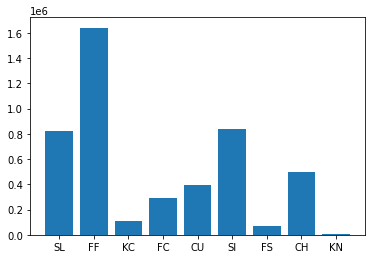

In [10]:
counts = count_by_factor(list(data["pitch_type"]))
plt.bar(counts.keys(),counts.values())
plt.show()

#### Filtering the Response Variable

As this analysis focuses on pitches that result in a strike, a binary variable is created to encode if the event occurs; to reduce the noise within the data, extremely uncommon events (e.g., intentional balls) will be filtered from the dataset. Additionally, a boolean variable will be created to represent if each observation resulted in the desired outcome.

It should be noted that fouls are being counted as strikes, regardless of the count when the pitch was thrown -- from the perspective of the pitcher, a foul is (typically) not a ball-in-play; so, the occurrence of one should be 'rewarded,' in a sense.

In [11]:
strikes = ["swinging_strike","swinging_strike_blocked","called_strike","missed_bunt","foul","foul_tip","bunt_foul_tip"]
data["isStrike"] = data["description"].isin(strikes)

final_data = data.drop("description",axis=1,inplace=False)

In [12]:
final_data.head()

,pitch_type,release_speed,release_pos_x,release_pos_z,zone,p_throws,pfx_x,pfx_z,plate_x,plate_z,spin_axis,isStrike
0,SL,89.2,-0.06,6.14,14.0,R,0.41,0.37,1.05,2.39,137.0,False
1,FF,93.9,-0.18,5.94,8.0,R,-0.33,1.57,0.06,2.08,210.0,False
2,FF,93.0,-0.09,5.97,8.0,R,-0.20,1.63,0.04,1.57,212.0,False
3,SL,88.1,-0.15,6.03,14.0,R,0.61,0.21,0.92,1.43,120.0,False
4,SL,89.0,-0.25,6.06,8.0,R,0.40,0.48,0.11,2.27,121.0,True


#### One-Hot Encoding and Standardizing

Categorical variables in the dataset are one-hot encoded (e.g., pitcher-handedness, pitch type, event) to aid the XGBoost-modeling process, converting a multi-level factor into a binary matrix. As an exercise, this analysis will utilize a wrapper for the popular <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html">sklearn.preprocessing.OneHotEncoder</a> function, the function <a href="https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html#sklearn-compose-make-column-transformer">sklearn.compose.make_column_transformer</a> function.

In [13]:
cat = ["pitch_type","zone","p_throws"]
num = ["release_speed","release_pos_x","release_pos_z","pfx_x","pfx_z","plate_x","plate_z","spin_axis"]

preprocesser_feature = make_column_transformer(
    (OneHotEncoder(handle_unknown="ignore"),cat),
    (StandardScaler(),num),
    remainder='passthrough'
)

In [14]:
processed_data = pd.DataFrame(preprocesser_feature.fit_transform(final_data))

In [15]:
processed_data.columns = preprocesser_feature.get_feature_names_out()

In [16]:
processed_data.head()

,onehotencoder__pitch_type_CH,onehotencoder__pitch_type_CU,onehotencoder__pitch_type_FC,onehotencoder__pitch_type_FF,onehotencoder__pitch_type_FS,onehotencoder__pitch_type_KC,onehotencoder__pitch_type_KN,onehotencoder__pitch_type_SI,onehotencoder__pitch_type_SL,onehotencoder__zone_1.0,...,onehotencoder__p_throws_R,standardscaler__release_speed,standardscaler__release_pos_x,standardscaler__release_pos_z,standardscaler__pfx_x,standardscaler__pfx_z,standardscaler__plate_x,standardscaler__plate_z,standardscaler__spin_axis,remainder__isStrike
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.073884,0.377312,0.537949,0.619432,-0.406447,1.188702,0.135595,-0.602010,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.856894,0.313682,0.145953,-0.221946,1.187432,0.031972,-0.187523,0.450462,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.706955,0.361404,0.204752,-0.074136,1.267126,0.008604,-0.719105,0.479297,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,-0.109374,0.329589,0.322351,0.846832,-0.618964,1.036808,-0.865029,-0.847106,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.040564,0.276564,0.381151,0.608062,-0.260341,0.090393,0.010517,-0.832689,1.0


### Introducing XGBoost

After having cleaned the dataset, focus shifts to training, testing, and tuning a model. First, the dataset is split into *training* and *testing* datasets.

In [17]:
X = processed_data.drop("remainder__isStrike",axis=1,inplace=False)
y = processed_data["remainder__isStrike"]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2) # Holdout datasets

It should be noted that, because the original data was already cleaned, the cleaning process does not need to be applied here; if, however, the data were split into these smaller datasets before cleaning, applying the above preprocesser would be necessary.

Next, introduce and **train** the XGBoost model.

In [19]:
xgb = XGBClassifier()
xgb.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

Having trained the model, introduce the testing dataset, predict observations, and observe the ROC curve. An article that greatly assisted in the creation and styling of the ROC and Precision plot below is linked <a href="https://towardsdatascience.com/model-validation-in-python-95e2f041f78c">here</a>.

In [20]:
y_pred = xgb.predict_proba(X_test)

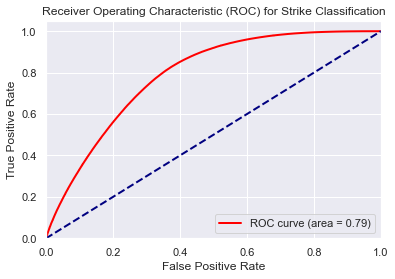

In [21]:
def ROCurve(y_test,y_pred):
    fpr, tpr, _ = roc_curve(y_test, y_pred[:,1]) # ROC needs probabilities of positive (1) class
    roc_auc = auc(fpr, tpr)
    sns.set()
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='red',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    
    return plt

roccurve = ROCurve(y_test,y_pred)
roccurve.title('Receiver Operating Characteristic (ROC) for Strike Classification')
roccurve.show()

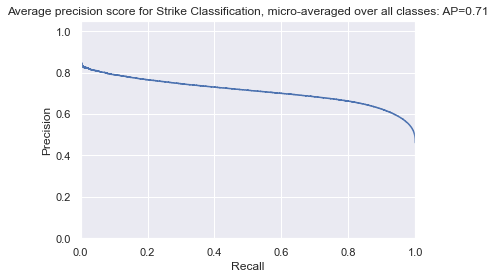

In [23]:
def PrecRecGraph(y_test,y_pred):
    precision, recall, _ = precision_recall_curve(y_test,y_pred[:,1])
    average_precision = average_precision_score(y_test, y_pred[:,1])
    sns.set()
    plt.figure()
    plt.step(recall, precision, where='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    return plt, average_precision

prgraph,average_precision = PrecRecGraph(y_test,y_pred)
prgraph.title(
   'Average precision score for Strike Classification, micro-averaged over all classes: AP={0:0.2f}'
   .format(average_precision))
prgraph.show()

#### Hyperparameter Tuning

Seldom does a machine-learning model reach peak performance without tuning; as such, the introduced XGBoost Classifier will be tuned according to <a href="">this guide on Kaggle</a>, which was incredibly useful.

In [24]:
space={'max_depth': hp.quniform("max_depth",3,18,1),
        'gamma': hp.uniform ('gamma',1,9),
        'reg_alpha' : hp.quniform('reg_alpha',40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda',0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree',0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight',0,10,1),
        'n_estimators': 200,
        'seed': 2023} # 'Prior' distributions for Bayesian optimization

def objective(space):
    xgb = XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']), min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']),
                    eval_metric="auc", early_stopping_rounds=10)
    
    evaluation = [( X_train, y_train), ( X_test, y_test)] # Using the same training/testing split
    
    xgb.fit(X_train, y_train,
            eval_set=evaluation,verbose=False) # Evaluate in the same manner as above
    

    pred = xgb.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5) # 50% threshold used as 'cutoff' for 'True'
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [25]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 20,
                        trials = trials) # 20 epochs used for brevity in report

SCORE:                                                                                                                 
0.7048581874051114                                                                                                     
SCORE:                                                                                                                 
0.705009046176693                                                                                                      
SCORE:                                                                                                                 
0.7049095435826711                                                                                                     
SCORE:                                                                                                                 
0.7049245224677927                                                                                                     
SCORE:                                  

In [27]:
bayesXGB = XGBClassifier(colsample_bytree = best_hyperparams["colsample_bytree"],
                         gamma = best_hyperparams["gamma"],
                         max_depth = int(best_hyperparams["max_depth"]),
                         min_child_weight = int(best_hyperparams["min_child_weight"]),
                         reg_alpha = int(best_hyperparams["reg_alpha"]),
                         reg_lambda = best_hyperparams["reg_lambda"],
                         eval_metric="auc")
                         
bayesXGB.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.5473413505056255, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=7.177469143275788, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_threshold=64,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=5, max_leaves=0,
              min_child_weight=7, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=0, ...)

In [28]:
y_pred = bayesXGB.predict_proba(X_test)

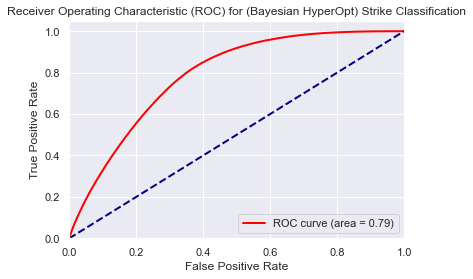

In [29]:
roccurve = ROCurve(y_test,y_pred)
roccurve.title('Receiver Operating Characteristic (ROC) for (Bayesian HyperOpt) Strike Classification')
roccurve.show()

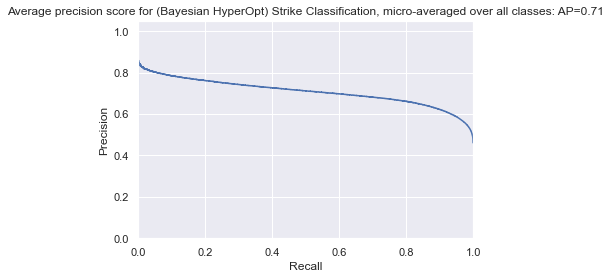

In [30]:
prgraph = PrecRecGraph(y_test,y_pred)
prgraph.title(
   'Average precision score for (Bayesian HyperOpt) Strike Classification, micro-averaged over all classes: AP={0:0.2f}'
   .format(average_precision))
prgraph.show()

As the goal in hyperparameter tuning is to bring the AUROC (Area Under ROC [Curve]) to 1.0, and to bring the Average Precision closer to 1.0, Bayesian Optimization succeeded, to an extent, in approaching that goal. Of course, no model is perfect -- cases in which machine learning models achieve such extreme success are rare and indicative of either overfitting on the training data, or a relatively simple relationship between variables.

### Evaluating Performance

Earlier, validation datasets were created, on which the (optimized) XGBoost classifier(s) might be evaluated to evaluate the performance of the created models.

In [31]:
y_pred_val = bayesXGB.predict_proba(X_val)

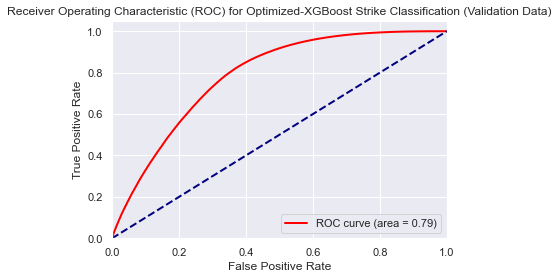

In [32]:
roccurve = ROCurve(y_val,y_pred_val)
roccurve.title('Receiver Operating Characteristic (ROC) for Optimized-XGBoost Strike Classification (Validation Data)')
roccurve.show()

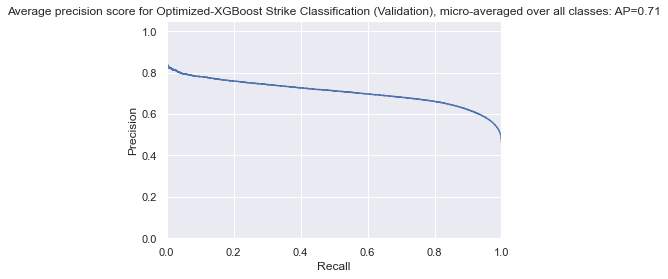

In [35]:
prgraph,average_precision = PrecRecGraph(y_val,y_pred_val)
prgraph.title(
   'Average precision score for Optimized-XGBoost Strike Classification (Validation), micro-averaged over all classes: AP={0:0.2f}'
   .format(average_precision))
prgraph.show()

As is evidenced by the graphs above, neither the average precision nor AUROC values worsened when exposed to the holdout dataset that trained the XGBoost model. This offers a bit of confidence in the model itself, in that extreme overfitting has been avoided.

#### Feature Importance

<AxesSubplot:>

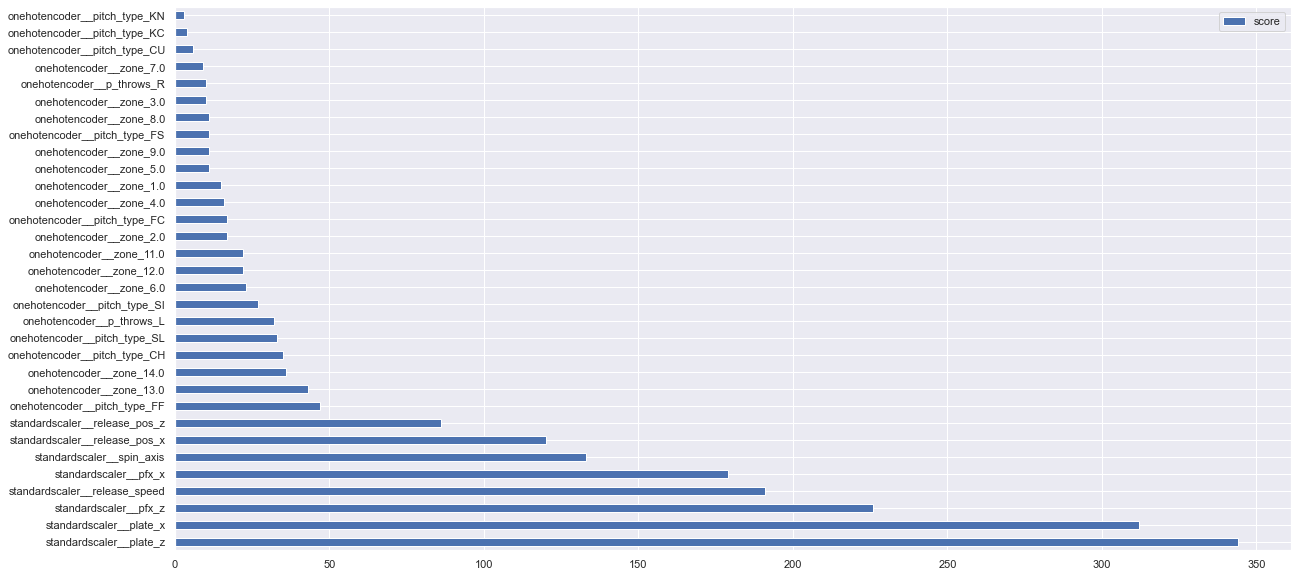

In [38]:
def featureImportance(xgb):
    feature_important = xgb.get_booster().get_score(importance_type='weight')
    keys = list(feature_important.keys())
    values = list(feature_important.values())

    ret = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
    return  ret.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) 

featureImportance(bayesXGB)

As intuition would have it, features such as **pitch location** (*plate_x,plate_z*), **pitch movement** (*pfx_x*,*pfx_z*), **release speed** (*release_pos_x*,*release_pos_z*), and **spin axis** are integral to producing strikes. Pitch types, by themselves, matter relatively little, although they themselves have different properties with respect to the aforementioned features. Similarly, while the zone also matters relatively little, the act of calling a pitch a 'strike' *is* performed by a human -- mistakes can be made; including this variable in the model is an appeal to pitches incorrectly called 'balls.'

### Conclusion and Future Work

#### Future Work

A possibly interesting feature left *out* of this model is the Pitcher themselves; different pitchers obviously excel at different aspects of the craft (e.g., Kershaw's curveball, Chapman's speed). However, the difference in sample size between pitchers could be an issue, depending on the years of data scraped and used to train the model. Future work could involve the incorporation of this metric, and others (e.g., *pitch count*, *runners on-base*), to inform the model of shifts in pitching tendencies and/or strategies.

*Additionally*, different optimization strategies and/or classification methods altogether (e.g., Random Forest, SVC) are also possible. A smaller goal within this analysis was for the author to become accustomed to XGBoost methods in Python 3.10, and so it was chosen as the modeling framework, both for its noted power and for having employed similar tactics at a collegiate level in R.

#### Conclusion

In this analysis, an XGBoost model classifying pitches as producing 'strikes' (including fouls) was created; the model revealed that features intrinsic to pitches, such as location, movement, speed, and spin, are indeed vital to generating strikes. 

A more *important* conclusion with creating this model is the ability to apply it to pitches thrown in *practices*! For example, a pitcher going through their arsenal might experiment with pitches (and variations), learning of what they are capable. This model can be applied to practice-based scenarios to understand the defensive potential of professional pitchers, or at the collegiate level (although the data source would no longer be PitchF/X).

For convenience, the Bayesian-optimized model will be saved in the repository linked with this analysis.

In [39]:
bayesXGB.save_model("./bayes.json")

### Repository Link